# Atividade prática 2

Projeto de um **algoritmo genético** que evolui uma população de strings até convergir para a seguinte string:

        METHINKS * IT * IS * LIKE * A * WEASEL

Para desenvolver um algoritmo com esse comportamento, segui a seguinte metodologia:

1. Definir os métodos de representação e avaliação dos indivíduos, bem como os operadores de variação
2. Inicializar a população
3. Selecionar pais
4. Gerar filhos
5. Selecionar sobreviventes

Na seção de Simulação, será executado o algoritmo. Por fim, na seção de Discussão, serão respondidos os questionamentos levantados no enunciado da atividade.


### Bibliotecas necessárias

In [10]:
# Função p/ cálculo de distância entre strings
from scipy.spatial.distance import hamming

# Geração de números aleatórios
import random as rd

# Operações numéricas
import numpy as np

# Plots
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Operações com strings
import string

In [11]:
alvo = 'METHINKS*IT*IS*LIKE*A*WEASEL'

---

## 1. Definir os métodos de representação e avaliação dos indivíduos, bem como os operadores de variação

#### 1.1 Representação

Cada indivíduo será representado por uma string com o mesmo comprimento da string-alvo e composta apenas por caracteres de espaço (*) e letras maiúsculas.

Apesar de números também serem permitidos na representação, optei por não utilizá-los porque a string-alvo não apresenta esses caracteres. Essas escolhas foram feitas para aumentar a velocidade de convergência do algoritmo.

#### 1.2 Avaliação

Para avaliar a aptidão dos indivíduos, será utilizado o critério de "distância" entre o mesmo e a string-alvo.

Essa "distância" será quantificada como a **distância Hamming** das duas strings, posto que esse método é pouco custoso computacionalmente e avalia a semelhança das strings em cada posição do vetor.

A implementação escolhida para este método é a da função _hamming()_, da biblioteca _scipy_. Essa função recebe duas strings e retorna o número de posições em que elas são diferentes. Por exemplo, _hamming(abc, abd)_ retorna 1, pois as strings divergem apenas no seu último caractere.

Assim, define-se a função de fitness de um indivíduo:

In [12]:
def fitness(indiv):
    
    # String-alvo, definida no início do código
    global alvo
    
    # Distância Hamming entre o indivíduo e a string-alvo
    dist = int(hamming(list(indiv), list(alvo))*len(alvo))
    
    return(dist)

#### 1.4 Variação

Nesta seção, são definidos os operadores de variação para a geração de novos indivíduos. Para este problema, optei por utilizar tanto a recombinação quanto a mutação para possibilitar uma exploração ampla do espaço de soluções, dado que existem muitas soluções candidatas possíveis.

##### 1.4.1 Recombinação (crossing-over)

Para a recombinação, será utilizado o operador de crossing-over com N pontos de corte para facilitar a convergência do algoritmo nos casos em que são necessárias mudanças locais nos indivíduos.

A estrutura da função de recombinação é semelhante à utilizada na atividade prática 1, baseada no pseudocódigo disponibilizado pelo professor. A diferença entre as funções é que a deste código não se limita a gerar permutações válidas dos elementos possíveis dos pais, uma vez que pode haver elementos repetidos, e utiliza N pontos de corte ao invés de apenas um.

In [13]:
def cutAndCrossfill(selectedParents, n, crossRate=1.0):
    
    parent1 = selectedParents[0]
    parent2 = selectedParents[1]
    
    # Seleciona n pontos de corte aleatórios, sem reposição
    cutPoints = sorted(rd.sample(range(len(parent1)), n))

    # Filho 1
    #
    # Inicializa a string do filho 1 com o primeiro trecho do pai 1
    child1 = parent1[:cutPoints[0]]
    #
    # Alterna entre os pais para criar o restante da string filho
    for i in range(len(cutPoints)-1):
        if i % 2 == 0:
            child1 += parent2[cutPoints[i]:cutPoints[i+1]]
        else:
            child1 += parent1[cutPoints[i]:cutPoints[i+1]]
    #
    # Adiciona o último trecho do pai 2 ao filho 1
    child1 += parent2[cutPoints[-1]:]
    
    # Filho 2
    #
    # Inicializa a string do filho 2 com o primeiro trecho do pai 2
    child2 = parent2[:cutPoints[0]]
    #
    # Alterna entre os pais para criar o restante da string filho
    for i in range(len(cutPoints)-1):
        if i % 2 == 0:
            child2 += parent1[cutPoints[i]:cutPoints[i+1]]
        else:
            child2 += parent2[cutPoints[i]:cutPoints[i+1]]
    #
    # Adiciona o último trecho do pai 1 ao filho 2
    child2 += parent1[cutPoints[-1]:]

    return (np.array([child1, child2]))


##### 1.4.2 Mutação

Para realizar a mutação nos indivíduos, haverá a probabilidade _mutationRate_ de cada caractere de um indivíduo ser substituído por outro caractere aleatório (entre os caracteres válidos).

In [14]:
def mutation(indiv, mutationRate=0.2):
    for i in range(len(indiv)):
        r = rd.random()
        if r < mutationRate:
            randChar = rd.choice(['*', *[chr(i) for i in range(ord('A'), ord('Z')+1)]])
            indiv = indiv[:i] + randChar + indiv[(i+1):]
    return(indiv)

---

## 2. Inicializar a população

A população será inicializada com _mu_ strings geradas aleatoriamente, sendo essa geração limitada pelas restrições de representação dos indivíduos (strings de mesmo tamanho que a string-alvo, contendo apenas asteriscos e letras maiúsculas).

In [15]:
def initializePopulation(mu=30):
    pop = np.array([])
    
    # Caracteres possíveis para a string
    characters = string.ascii_uppercase + '*'
    
    # String-alvo
    global alvo
    
    for i in range (mu):

        # Gera uma string aleatória com os caracteres possíveis
        indiv = ''.join(rd.choice(characters) for i in range(len(alvo)))
        
        # Adiciona indivíduo à população
        pop = np.append(pop, indiv)
        
    return(pop)

---

## 3. Selecionar pais

Para selecionar quais indivíduos gerarão novos indivíduos para a população, será utilizado o operador de torneio. _nselect_ indivíduos serão selecionados aleatoriamente e, entre eles, serão selecionados como pais os dois indivíduos com maior aptidão (no caso, os menores valores pra função de fitness).

In [16]:
def selectParents(pop, nselect=10):
    
    # Indexa indivíduos da população
    indexedPop = np.array([[i,j] for (i,j) in enumerate(pop)])

    # Seleciona nselect possíveis pais aleatoriamente
    possibleParents = indexedPop[rd.sample(range(indexedPop.shape[0]), nselect)]

    # Avalia a função de fitness para cada possível pai
    popFitness = np.array([[i, fitness(j)] for (i,j) in possibleParents])

    # Escolhe os dois pais com melhor fitness
    selectedParents = indexedPop[np.array([int(i) for i in popFitness[popFitness[:, 1].argsort()][0:2,0]])][:,1]

    return(selectedParents)

---

## 4. Gerar filhos

Na geração dos filhos, aplica-se a recombinação entre os pais selecionados e a mutação nos indivíduos gerados. Dessa forma, possibilita-se explorar novas regiões do espaço de soluções.

---

## 5. Selecionar sobreviventes

Para selecionar os indivíduos sobreviventes em cada geração, optou-se por utilizar a substituição baseada em fitness. Assim, após gerar os novos indivíduos e aplicar neles os operadores de variação, elimina-se da população os indivíduos menos aptos (ou seja, com maior valor da função de fitness).

Ao eliminar os indivíduos com menor aptidão, observa-se que a população volta a ter seu tamanho inicial.

In [17]:
def selectSurvivors(pop, offspringSize):
    pop = pop.copy()
    
    # Avalia todos os indivíduos da população
    popFitness = np.array([fitness(i) for i in pop])
    
    # Indexa o fitness calculado
    indexedFitness = np.array([[i,j] for (i,j) in enumerate(popFitness)])
    
    # Elimina os offspringSize últimos indivíduos menos aptos
    pop = pop[indexedFitness[indexedFitness[:,1].argsort()][0:-offspringSize,0]]
    return(pop)

---

## Simulação

### Funções auxiliares

In [18]:
# Retorna o melhor indivíduo da população
def bestIndividual(pop):
    indexedFitness = np.array([[i, fitness(j)] for (i,j) in enumerate(pop)])
    return(pop[indexedFitness[:,1].argsort()[0]])

# Colore a string do melhor indivíduo para mostrar a diferença entre ela e o alvo (cortesia do ChatGPT)
def colorizeString(s):
    global alvo
    colorized_s = ''
    for i, c in enumerate(s):
        if c == alvo[i]:
            colorized_s += f'\033[32m{c}\033[0m'  # adiciona o caractere verde
        else:
            colorized_s += f'\033[31m{c}\033[0m'  # adiciona o caractere vermelho
    return colorized_s

[ITER 0] Melhor indivíduo: DEVOSTMVZIQYIQNQYKESSCQOFPXU (fitness = 23)
[ITER 1] Melhor indivíduo: OETOZTBVMIEYIGYQYKEBS*DAFQSM (fitness = 21)
[ITER 2] Melhor indivíduo: OETOZTTWMIE*W*YOYKEBR*NAAQXM (fitness = 20)
[ITER 3] Melhor indivíduo: OETOFZTWOIT*H*YLIKEBW*GCFQSM (fitness = 18)
[ITER 4] Melhor indivíduo: XETOXZTTRIE*VIYLIKE*W*GYMSWM (fitness = 17)
[ITER 5] Melhor indivíduo: XETOXZNXRIE*IITLIKE*W*IEMQWM (fitness = 16)
[ITER 6] Melhor indivíduo: XETOXZNXRIE*IITLIKE*W*IEMQWM (fitness = 16)
[ITER 7] Melhor indivíduo: XETOXZNXRIE*IITLIKE*W*IEMQWM (fitness = 16)
[ITER 8] Melhor indivíduo: XETOXZNXRIE*IITLIKE*W*IEMQWM (fitness = 16)
[ITER 9] Melhor indivíduo: XETCXHPB*IQ*IIXLIKE*S*WYMAWM (fitness = 15)
[ITER 10] Melhor indivíduo: XETCXHPB*IQ*IIXLIKE*S*WYMAWM (fitness = 15)
[ITER 11] Melhor indivíduo: XETCBUPB*IQ*IIXLIKE*S*WEMQWM (fitness = 14)
[ITER 12] Melhor indivíduo: XETCBUPB*IQ*IIXLIKE*S*WEMQWM (fitness = 14)
[ITER 13] Melhor indivíduo: XETCBUPB*IQ*IIXLIKE*S*WEMQWM (fitness = 14)
[I

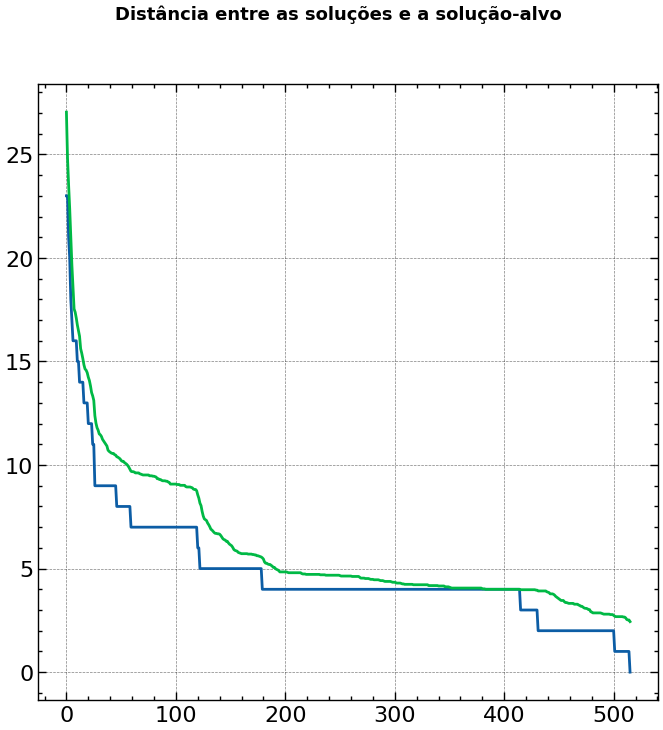

In [20]:
plt.figure(figsize=(8,8))
plt.suptitle('Distância entre as soluções e a solução-alvo', size=13, fontweight='semibold')

# Parâmetros pra função de variação da taxa de mutação
maxMutation = 0.45
minMutation = 0.08
maxDist = 28
minDist = 1

# Taxas de crossover e mutação
crossoverRate = 0.9
mutationRate = maxMutation

# Tamanho da população e quantidade de filhos por geração
popSize = 50
offspringRate = 0.7
offspringSize = int(popSize*offspringRate - (popSize*offspringRate)%2)

# Geração da população inicial
pop = initializePopulation(popSize)

# Avaliação dos membros da população inicial
popFitness = np.array([fitness(solution) for solution in pop])

# Melhor solução na população original
solMelhorVec = np.min(popFitness)
solBestIndivVec = bestIndividual(pop)
solMediaVec = np.mean(popFitness)

maxiter = 3000
solOtima = False
niter = 0

while(niter < maxiter and solOtima==False):
    
    newPop = pop
    
    # Gera filhos
    for _ in range(int(offspringSize/2)):
        # Seleção dos melhores pais
        selectedParents = selectParents(pop, int(0.9*popSize)) # diminuir torneio p/ dificultar pegar individuos repetidos
        
        # Recombinação dos pais escolhidos para gerar 2 descendentes
        offspring = cutAndCrossfill(selectedParents, 27, crossoverRate)
        
        # Mutação (ou não) dos indivíduos da população
        offspring = np.array([mutation(individuo) for individuo in offspring])
        newPop = np.concatenate([newPop, offspring])
    pop = newPop
    
    # Seleção dos indivíduos mais aptos
    pop = selectSurvivors(pop, offspringSize)
    
    # Avaliação da população
    popFitness = np.array([fitness(solution) for solution in pop])
    
    bestFitness = np.min(popFitness)
    meanFitness = np.mean(popFitness)
    bestIndiv = bestIndividual(pop)
    
    # Prepara plot dos resultados ao longo do tempo
    solMelhorVec = np.append(solMelhorVec, bestFitness)
    solBestIndivVec = np.append(solBestIndivVec, bestIndiv)
    solMediaVec = np.append(solMediaVec, meanFitness)
    
    # Analisa se a solução ótima foi alcançada
    if bestFitness == 0.0:
        solOtima = True
    
    # Atualiza taxa de mutação de forma que ela chegue a minMutation quando a distância até o alvo for 1
    mutationRate = maxMutation + ((minMutation-maxMutation)/(minDist-maxDist))*(bestFitness-maxDist)
    
    print(f'[ITER {niter}] Melhor indivíduo: {colorizeString(bestIndiv)} (fitness = {fitness(bestIndiv)})')

    niter += 1

plt.plot(solMelhorVec)
plt.plot(solMediaVec)

plt.show()

---

## Discussão

- #### Função de aptidão

A definição da função de aptidão dos indivíduos foi o fator mais determinante para a convergência do algoritmo. Inicialmente, eu utilizei a distância de edição - ou distância de Levenshtein - para realizar essa avaliação, retornando a quantidade de deleções ou adições de caracteres que precisavam ser realizadas para que o indivíduo se tornasse a string-alvo. Porém, ao avaliar melhor a métrica, percebi que ela era ideal apenas caso as strings fossem de tamanhos diferentes, sendo a função pouco eficaz na diferenciação entre strings muito parecidas, mas deslocadas entre si, como "METHINKS IT IS LIKE A WEASEL" e "*METHINKS IT IS LIKE A WEASE", o que ocasionava problemas quando a população começava a convergir para o alvo.

A métrica de maior sucesso nesse caso foi a distância Hamming, que considera que as strings têm mesmo tamanho e apenas compara se os caracteres em uma mesma posição são iguais nas duas palavras.

- #### Dimensão do espaço de busca

Como os cada gene de um indivíduo é uma das as 26 letras do alfabeto em maiúsculo ou um asterisco (*) e cada indivíduo tem 28 genes, tem-se que a quantidade de strings possíveis é N, tal que:

N = 27^28 = 11,97*(10^39) possibilidades

Desse modo, como a string-alvo é uma entre todas essas possibilidades, a probabilidade dela ser gerada aleatoriamente é de:

p = 1/N = 8,35*(10^-41)

O algoritmo genético supera essa probabilidade praticamente nula restringindo o espaço de soluções, mantendo na população os indivíduos com mais caracteres no lugar correto. A cada caractere correto, o espaço de busca é reduzido 28 vezes, dado que só é necessário explorar as possibilidades das posições restantes da string. Além disso, o algoritmo permite uma exploração eficiente e paralelizada do espaço de busca, gerando combinações e mutações dos indivíduos em uma mesma população e selecionando aqueles que mais se aproximam do alvo.

- #### Número médio de iterações até a convergência

O número de gerações até a convergência é fortemente dependente do tamanho da população inicial. Por razões de tempo de execução, estou utilizando uma população de apenas 50 indivíduos. Para esse tamanho de população, eu obtive como número médio de iterações até a convergência 720.9 iterações, resultado obtido executando 30 vezes o algoritmo. Além disso, vale ressaltar que, em nenhum caso, foi atingido o número máximo de iterações (3000). O número mínimo de iterações foi 309 e o número máximo foi 1535.

- #### Probabilidade de mutação

A probabilidade de mutação foi outro fator muito determinante para a convergência do algoritmo. Inicialmente, eu utilizei uma probabilidade muito alta (> 0.6), o que ocasionou problemas quando a população se aproximava da string-alvo, posto que os novos indivíduos precisavam mudar muito pouco para atingir o resultado esperado e, com a probabilidade de mutação muito alta, a chance disso ocorrer era muito pequena. Por outro lado, com a probabilidade muito baixa, a população demorava muito para chegar em bons resultados, principalmente quando havia poucos filhos por geração. Para tirar proveito desse _tradeoff_, eu implementei uma probabilidade de mutação variável, que diminui linearmente à medida que o melhor indivíduo se aproxima da solução-alvo, indo de 0.45 (valor máximo de mutação) a 0.05 (valor mínimo de mutação). Com essa mudança, a população convergia rapidamente para uma boa solução e, quando se aproximava do alvo, sofria apenas pequenas alterações no seu genótipo.

- #### Probabilidade de recombinação

A probabilidade de recombinação também foi um hiperparâmetro essencial para o bom desempenho do algoritmo, posto que, quando a população se aproxima da solução-alvo, combinações entre bons indivíduos permitem uma exploração local das soluções e uma convergência mais provável para a string-alvo. Em todos os casos, probabilidades altas de recombinação me retornaram os melhores resultados, posto que é uma operação desejável tanto nas primeiras quanto nas últimas iterações. Em especial, a probabilidade alta de recombinação associada a um _crossing-over_ com muitos pontos de corte favoreceu fortemente a convergência, permitindo mudanças pequenas nas strings nas gerações finais.